In [1]:
import pandas as pd
import numpy as np

In [2]:
#pip install git+https://github.com/quantopian/pyfolio
# import again if first time not work
import pyfolio

/Users/jvsingh/anaconda3/envs/rlproject/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [3]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline

## S&P500

In [4]:
def get_benchmark_returns(bmk_tic="^GSPC"):
    df = pd.read_csv("data/wd_te.csv", parse_dates =['Date'])
    df["Date"] = [d.date() for d in df.Date]
    df = df.loc[df.tic == bmk_tic,["Date","returns_close"]]\
            .reset_index(drop=True)\
            .rename(columns={"returns_close":"daily_return"})
    df["strat"] = bmk_tic
    return df[["Date", "strat","daily_return"]]

bmk = "^GSPC"
bmk_returns = get_benchmark_returns(bmk_tic="^GSPC")
bmk_returns

,Date,strat,daily_return
0,2005-12-01,^GSPC,0.012157
1,2005-12-02,^GSPC,0.000324
2,2005-12-05,^GSPC,-0.002363
3,2005-12-06,^GSPC,0.001276
4,2005-12-07,^GSPC,-0.005009
...,...,...,...
4023,2021-11-24,^GSPC,0.002294
4024,2021-11-26,^GSPC,-0.022725
4025,2021-11-29,^GSPC,0.013200
4026,2021-11-30,^GSPC,-0.018961


## Ensemble Strategy

First we collect result files data

In [5]:
# Result
result_files = {"ens01_0": {"wts":"2021.12.12.022502_trading_weights_df_90_60_0.csv",
	                   "rets":"2021.12.12.022502_trading_value_returns_df_90_60_0.csv"
					  },
					  
			  "ens02_0.5": {"wts":"2021.12.12.024442_trading_weights_df_90_60_0.5.csv",
			  	       "rets":"2021.12.12.024442_trading_value_returns_df_90_60_0.5.csv"
			  		  },
                
              "ens03_1.5":{
                "wts":"2021.12.12.103504_trading_weights_df_90_60_1.5.csv",
                "rets":"2021.12.12.103504_trading_value_returns_df_90_60_1.5.csv"
               },
               
						
			  "ens04_2.0": {"wts":"2021.12.12.024523_trading_weights_df_90_60_2.0.csv",
			  	       "rets":"2021.12.12.024523_trading_value_returns_df_90_60_2.0.csv"
			  		  },
					  
					  
			  "ens05_5": {"wts":"2021.12.12.024627_trading_weights_df_90_60_5.csv",
			  	       "rets":"2021.12.12.024627_trading_value_returns_df_90_60_5.csv"
			  		  },
					  
			"ens06_7.5": {"wts":"2021.12.12.055939_trading_weights_df_90_60_7.5.csv",
			  	       "rets":"2021.12.12.055939_trading_value_returns_df_90_60_7.5.csv"
			  		  },
					  
			  "ens07_10": {"wts":"2021.12.12.050946_trading_weights_df_90_60_10.0.csv",
			  	       "rets":"2021.12.12.050946_trading_value_returns_df_90_60_10.0.csv"
			  		  },
                
                "ens08_10": {"wts":"2021.12.12.102959_trading_weights_df_90_60_20.0.csv",
			  	       "rets":"2021.12.12.102959_trading_value_returns_df_90_60_20.0.csv"
			  		  }
					  	  
               }

# Chosen hypothetical mid risk averseness
ENS = "ens05_5"

In [19]:
def read_returns_files(result_files):
    returns_out_list=[]
    for k,v in result_files.items():
        filename = result_files[k]["rets"]
        filepath = f"results/{filename}"
        # Date  account_value  daily_return       tc_cost
        df = pd.read_csv(filepath, parse_dates =['Date'])
        df["Date"] = [d.date() for d in df.Date]
        df["strat"] = k
        df = df.loc[:,["Date","strat" ,"account_value","daily_return", "tc_cost"]]
        returns_out_list.append(df)
        #print(df)  
    returns_df = pd.concat(returns_out_list)
    returns_df = returns_df.sort_values(by=["Date","strat"])
    
    return returns_df

def read_weights_files(result_files):
    weights_out_list=[]
    for k,v in result_files.items():
        filename = result_files[k]["wts"]
        filepath = f"results/{filename}"
        # Date  account_value  daily_return       tc_cost
        df = pd.read_csv(filepath, parse_dates =['Date'])
        df["Date"] = [d.date() for d in df.Date]
        df["strat"] = k
        df = df.loc[:,["Date","strat","tic","new_weight","pre_weights"]]
        weights_out_list.append(df)
        #print(df)  
    weights_df = pd.concat(weights_out_list)
    weights_df = weights_df.sort_values(by=["Date","strat"])
    return weights_df
    
strat_returns = read_returns_files(result_files)
strat_returns

,Date,strat,account_value,daily_return,tc_cost
0,2006-04-10,ens01_0,1.000000e+06,NaN,NaN
0,2006-04-10,ens02_0.5,1.000000e+06,NaN,NaN
0,2006-04-10,ens03_1.5,1.000000e+06,NaN,NaN
0,2006-04-10,ens04_2.0,1.000000e+06,NaN,NaN
0,2006-04-10,ens05_5,1.000000e+06,NaN,NaN
...,...,...,...,...,...
3939,2021-12-01,ens04_2.0,3.544186e+06,-0.005395,1.541596e-04
3939,2021-12-01,ens05_5,4.017033e+06,-0.001691,1.184559e-04
3939,2021-12-01,ens06_7.5,3.068666e+06,-0.007073,7.202141e-07
3939,2021-12-01,ens07_10,3.305904e+06,-0.005193,1.147173e-04


In [20]:
weights_df

,Date,strat,tic,new_weight,pre_weights
0,2006-04-11,ens01_0,LQD,1.244409e-01,0.070582
1,2006-04-11,ens01_0,SHY,1.248625e-01,0.070441
2,2006-04-11,ens01_0,IEF,1.240135e-01,0.070510
3,2006-04-11,ens01_0,TLT,1.253352e-01,0.070627
4,2006-04-11,ens01_0,AGG,1.253352e-01,0.070523
...,...,...,...,...,...
47263,2021-12-01,ens08_10,IVV,1.246280e-01,0.021252
47264,2021-12-01,ens08_10,IVE,1.241278e-08,0.000068
47265,2021-12-01,ens08_10,IVW,1.248684e-01,0.108647
47266,2021-12-01,ens08_10,SPY,1.248163e-01,0.106014


In [7]:
all_return = pd.concat([bmk_returns,strat_returns[["Date", "strat", "daily_return"]]])
all_return_pivot = all_return.pivot(index='Date', columns='strat', values='daily_return')
all_return_pivot = all_return_pivot.dropna()
all_return_pivot

strat,^GSPC,ens01_0,ens02_0.5,ens03_1.5,ens04_2.0,ens05_5,ens06_7.5,ens07_10,ens08_10
Date,,,,,,,,,
2006-04-11,-0.007751,-0.005392,-0.005392,-0.005392,-0.005392,-0.005392,-0.005392,-0.005392,-0.005392
2006-04-12,0.001205,-0.000030,-0.000641,0.002337,0.001406,0.000838,-0.000621,0.002256,0.000224
2006-04-13,0.000776,0.000208,-0.002559,-0.000086,-0.001456,-0.002090,0.000078,-0.000356,-0.001099
2006-04-17,-0.002940,0.006539,0.000908,0.004648,-0.001627,0.000806,-0.001335,0.005370,0.000028
2006-04-18,0.017077,0.009564,0.005048,0.011196,0.012111,0.005757,0.012731,0.011512,0.010140
...,...,...,...,...,...,...,...,...,...
2021-11-24,0.002294,0.000077,0.003783,0.002563,0.002681,0.003314,0.002708,0.002255,0.001566
2021-11-26,-0.022725,-0.004455,-0.001524,-0.006032,-0.009482,-0.008471,-0.011866,-0.012523,-0.011401
2021-11-29,0.013200,0.000369,0.002188,0.001749,0.001493,0.002309,0.003036,0.001033,0.003458


In [8]:
all_return_pivot.apply(lambda x: np.cumprod(1+x))

strat,^GSPC,ens01_0,ens02_0.5,ens03_1.5,ens04_2.0,ens05_5,ens06_7.5,ens07_10,ens08_10
Date,,,,,,,,,
2006-04-11,0.992249,0.994608,0.994608,0.994608,0.994608,0.994608,0.994608,0.994608,0.994608
2006-04-12,0.993444,0.994578,0.993970,0.996932,0.996006,0.995441,0.993990,0.996851,0.994830
2006-04-13,0.994216,0.994784,0.991426,0.996847,0.994556,0.993360,0.994068,0.996496,0.993737
2006-04-17,0.991293,1.001289,0.992326,1.001480,0.992938,0.994162,0.992741,1.001847,0.993765
2006-04-18,1.008221,1.010865,0.997335,1.012693,1.004963,0.999885,1.005379,1.013380,1.003842
...,...,...,...,...,...,...,...,...,...
2021-11-24,3.625935,3.737899,3.606262,4.054717,3.629123,4.033700,3.152171,3.383260,3.276432
2021-11-26,3.543536,3.721247,3.600764,4.030258,3.594711,3.999529,3.114767,3.340892,3.239079
2021-11-29,3.590312,3.722619,3.608643,4.037307,3.600080,4.008763,3.124224,3.344344,3.250281


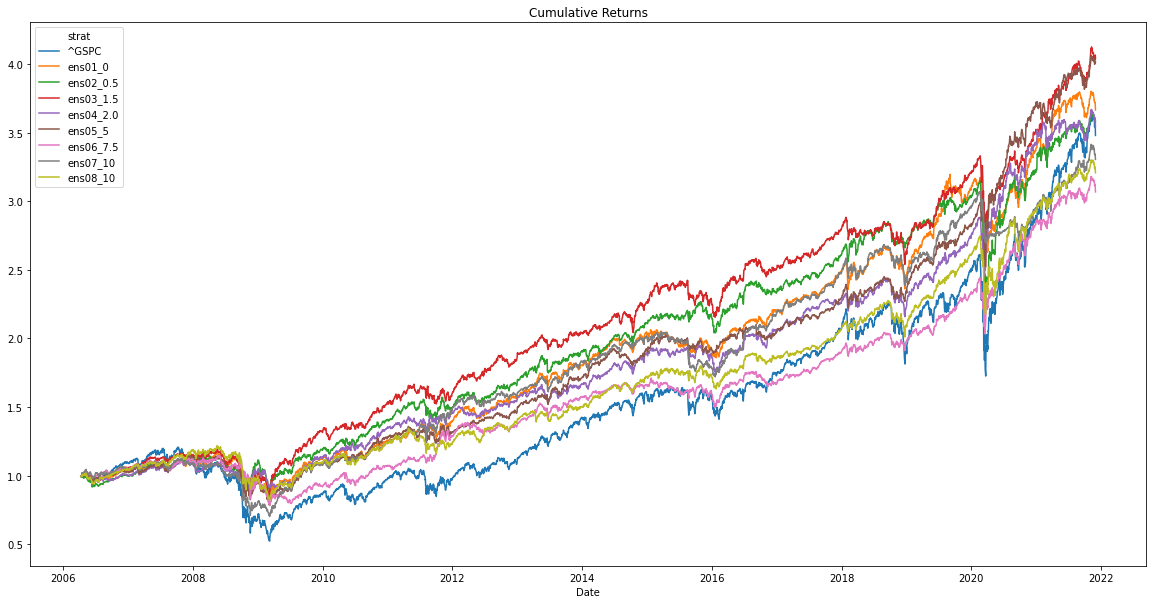

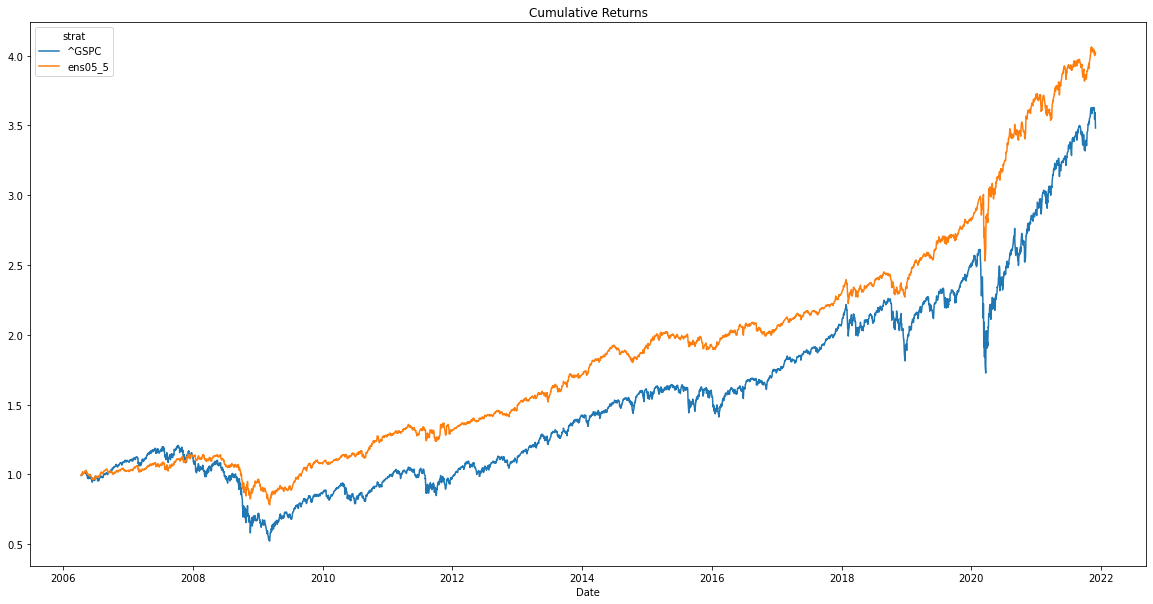

In [9]:
all_return_pivot.apply(lambda x: np.cumprod(1+x)).plot(figsize=(20,10), title="Cumulative Returns")
all_return_pivot.apply(lambda x: np.cumprod(1+x))[[bmk,ENS]].plot(figsize=(20,10), title="Cumulative Returns")

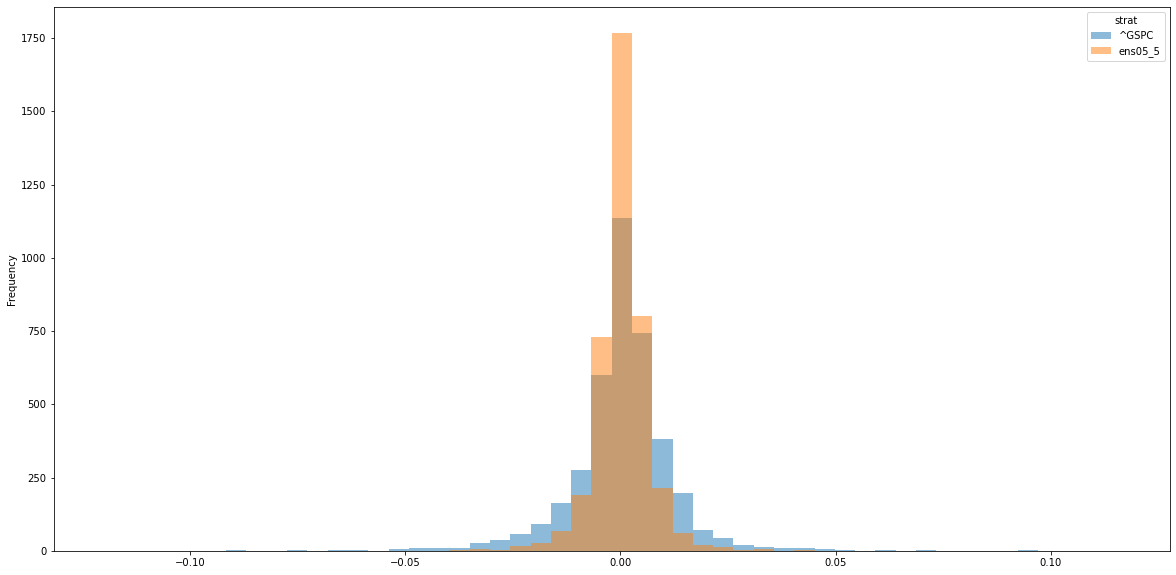

In [10]:
all_return_pivot[[bmk,ENS]].plot.hist(figsize=(20,10), bins=50, alpha=0.5)

In [11]:
def get_sharpe(all_return_pivot):
    return np.sqrt(252.0)*all_return_pivot.apply(lambda x: np.mean(x)/np.std(x),0)
   
get_sharpe(all_return_pivot)

strat
^GSPC        0.498842
ens01_0      0.818023
ens02_0.5    0.818964
ens03_1.5    0.872940
ens04_2.0    0.817754
ens05_5      0.906177
ens06_7.5    0.700387
ens07_10     0.765902
ens08_10     0.729860
dtype: float64

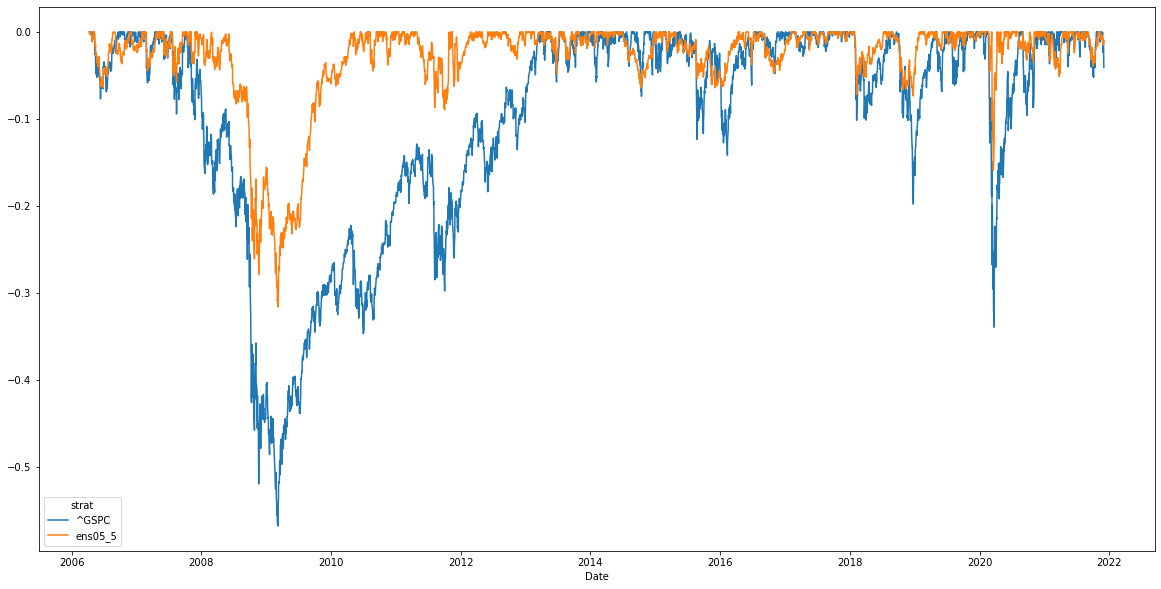

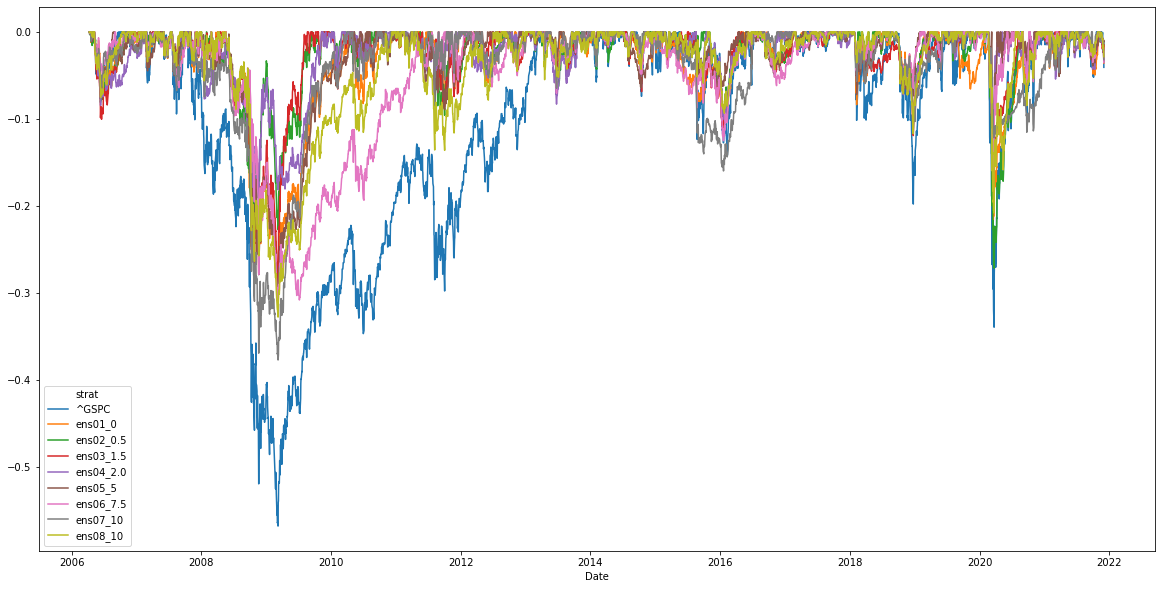

In [12]:
# Calculate max drawdown
def get_max_ddn(p_returns):
    wealth = (1.0 + p_returns).cumprod()
    #print(wealth)
    prev_peaks = wealth.cummax()
    #print(prev_peaks)
    drawdows = (wealth - prev_peaks)/prev_peaks
    return drawdows


max_ddns = all_return_pivot.apply(lambda x: get_max_ddn(x), 0)
max_ddns[[bmk,ENS]].plot(figsize=(20,10))
max_ddns.plot(figsize=(20,10))

In [13]:
def backtest_strat(df):
    print(df.columns)
    colname = df.columns[1]
    strategy_ret= df.copy()
    strategy_ret['Date'] = pd.to_datetime(strategy_ret['Date'])
    strategy_ret.set_index('Date', drop = False, inplace = True)
    strategy_ret.index = strategy_ret.index.tz_localize('UTC')
    del strategy_ret['Date']
    ts = pd.Series(strategy_ret.iloc[:,0].values, index=strategy_ret.index)
    return ts.rename(colname)

bmk_series = backtest_strat(all_return_pivot[[bmk,ENS]].reset_index()[["Date",bmk]])
ensemble_series = backtest_strat(all_return_pivot[[bmk,ENS]].reset_index()[["Date",ENS]])


Index(['Date', '^GSPC'], dtype='object', name='strat')
Index(['Date', 'ens05_5'], dtype='object', name='strat')


### Full Results 

Select ensemble(`ENS`) and benchmark(`bmk`)

Start date,2006-04-11
End date,2021-12-01
Total months,187
,Backtest
Annual return,9.3%
Cumulative returns,301.7%
Annual volatility,10.4%
Sharpe ratio,0.91
Calmar ratio,0.29
Stability,0.95
Max drawdown,-31.6%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,31.60,2007-12-06,2009-03-09,2010-05-12,635
1,15.88,2020-03-10,2020-03-19,2020-04-09,23
2,8.94,2011-04-29,2011-10-03,2011-11-07,137
3,7.36,2018-08-29,2018-12-24,2019-01-30,111
4,7.20,2018-01-26,2018-02-08,2018-07-12,120


Stress Events,mean,min,max
Lehman,-0.14%,-3.03%,1.44%
US downgrade/European Debt Crisis,0.07%,-3.59%,3.42%
Fukushima,0.13%,-0.21%,0.78%
EZB IR Event,-0.08%,-1.04%,0.61%
Aug07,0.10%,-2.00%,1.58%
Mar08,-0.08%,-1.77%,1.47%
Sept08,-0.27%,-3.03%,1.40%
2009Q1,-0.37%,-3.61%,3.28%
2009Q2,0.15%,-2.96%,3.38%
Flash Crash,-0.03%,-0.71%,0.97%


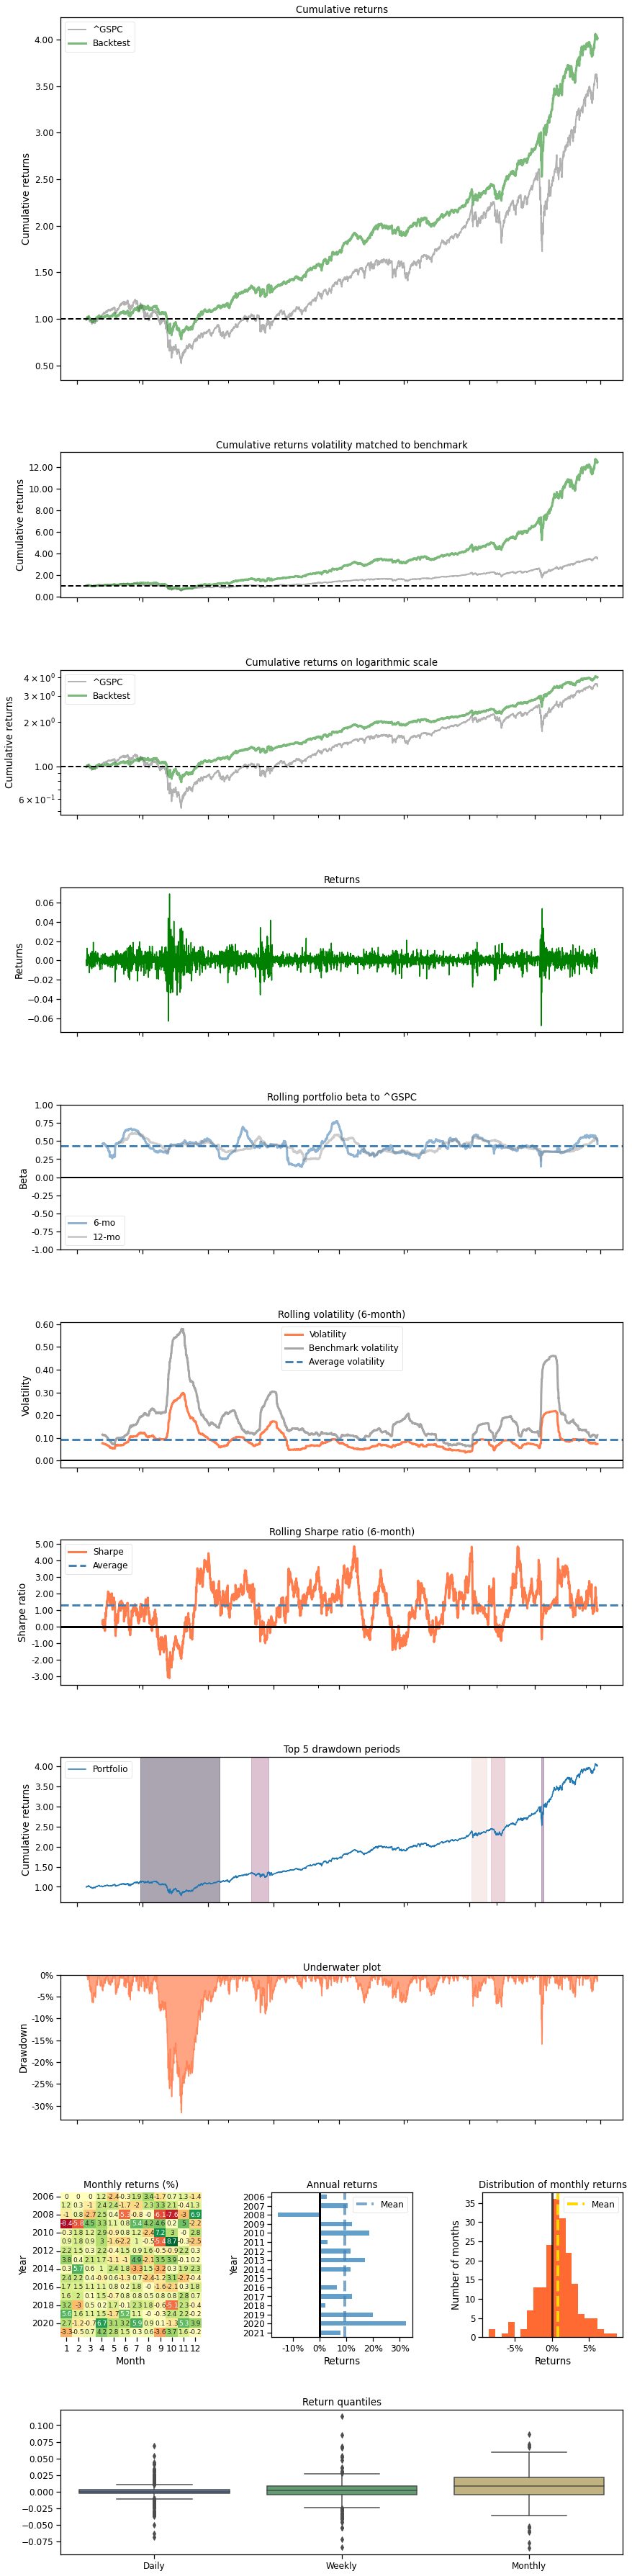

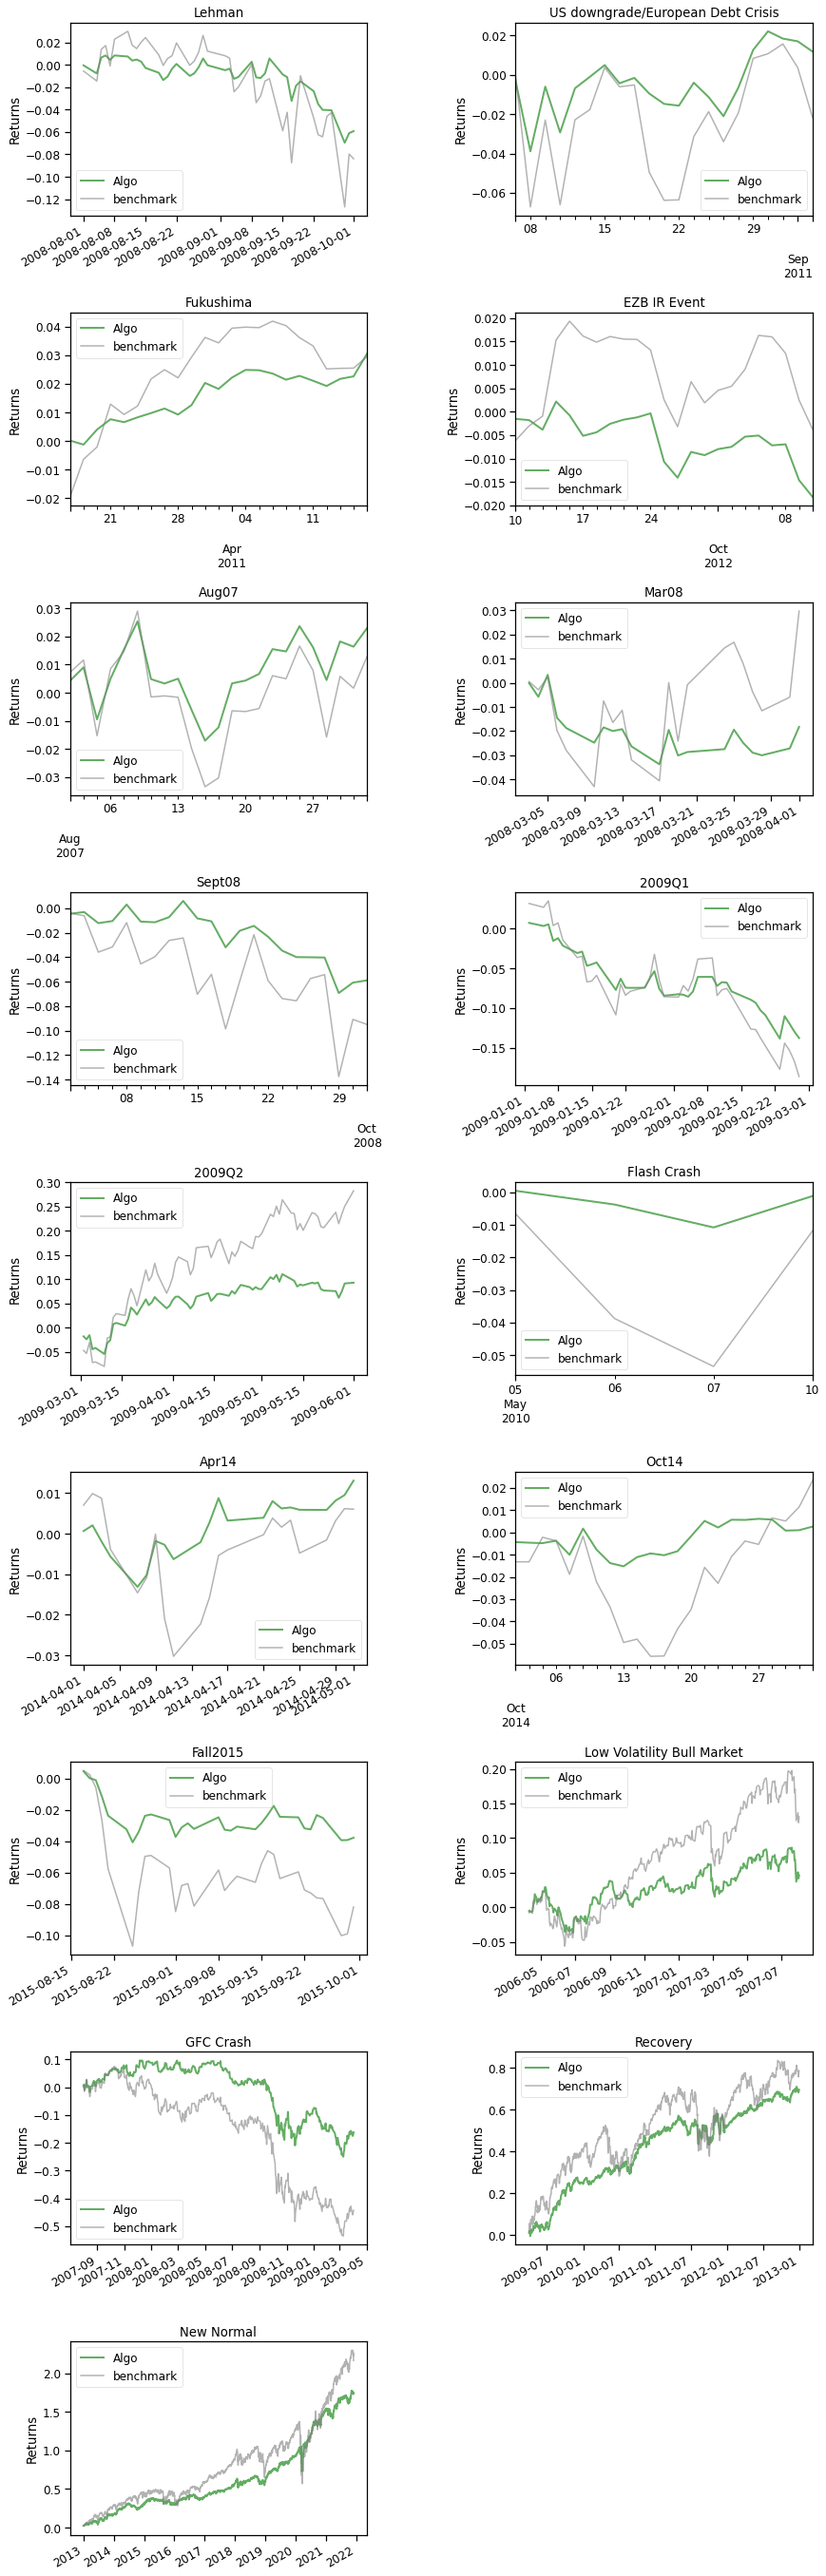

In [14]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = ensemble_series,
                                   benchmark_rets=bmk_series, set_context=False)

### Optional weights analysis

In [36]:
### Weights

def asset_types():
    INVESTABLE_ASSETS = dict(# Bonds
                              bonds = ["LQD", "SHY", "IEF", "TLT", "AGG"], 
                              # Equities  
                              equities = ["IJH", "IJR", "IVV", "IVE", "IVW","SPY"], # "^GSPC"
                              # Commodities
                              commodities = ["GLD"])

    num_asset_classes = len(INVESTABLE_ASSETS.keys())
    bonds = INVESTABLE_ASSETS["bonds"]
    equities = INVESTABLE_ASSETS["equities"]
    commodities = INVESTABLE_ASSETS["commodities"]
    investable_tic = bonds + equities + commodities

    asset_type_list = []
    for k,v in INVESTABLE_ASSETS.items():
        x = pd.DataFrame({"tic":v})
        x["asset_type"] = k
        asset_type_list.append(x)
    return pd.concat(asset_type_list)
    
    
def read_weights_files(result_files):
    weights_out_list=[]
    for k,v in result_files.items():
        filename = result_files[k]["wts"]
        filepath = f"results/{filename}"
        # Date  account_value  daily_return       tc_cost
        df = pd.read_csv(filepath, parse_dates =['Date'])
        df["Date"] = [d.date() for d in df.Date]
        df["strat"] = k
        df = df.loc[:,["Date","strat","tic","new_weight","pre_weights"]]
        weights_out_list.append(df)
        #print(df)  
    weights_df = pd.concat(weights_out_list)
    weights_df = weights_df.sort_values(by=["Date","strat"])
    return weights_df
    
weights_df = read_weights_files(result_files)

In [37]:
weights_df

,Date,strat,tic,new_weight,pre_weights
0,2006-04-11,ens01_0,LQD,1.244409e-01,0.070582
1,2006-04-11,ens01_0,SHY,1.248625e-01,0.070441
2,2006-04-11,ens01_0,IEF,1.240135e-01,0.070510
3,2006-04-11,ens01_0,TLT,1.253352e-01,0.070627
4,2006-04-11,ens01_0,AGG,1.253352e-01,0.070523
...,...,...,...,...,...
47263,2021-12-01,ens08_10,IVV,1.246280e-01,0.021252
47264,2021-12-01,ens08_10,IVE,1.241278e-08,0.000068
47265,2021-12-01,ens08_10,IVW,1.248684e-01,0.108647
47266,2021-12-01,ens08_10,SPY,1.248163e-01,0.106014


In [41]:
asset_types()

,tic,asset_type
0,LQD,bonds
1,SHY,bonds
2,IEF,bonds
3,TLT,bonds
4,AGG,bonds
0,IJH,equities
1,IJR,equities
2,IVV,equities
3,IVE,equities
4,IVW,equities


In [45]:
weights_df.merge(asset_types(), how="left", left_on=["tic"], right_on=["tic"])

,Date,strat,tic,new_weight,pre_weights,asset_type
0,2006-04-11,ens01_0,LQD,1.244409e-01,0.070582,bonds
1,2006-04-11,ens01_0,SHY,1.248625e-01,0.070441,bonds
2,2006-04-11,ens01_0,IEF,1.240135e-01,0.070510,bonds
3,2006-04-11,ens01_0,TLT,1.253352e-01,0.070627,bonds
4,2006-04-11,ens01_0,AGG,1.253352e-01,0.070523,bonds
...,...,...,...,...,...,...
378139,2021-12-01,ens08_10,IVV,1.246280e-01,0.021252,equities
378140,2021-12-01,ens08_10,IVE,1.241278e-08,0.000068,equities
378141,2021-12-01,ens08_10,IVW,1.248684e-01,0.108647,equities
378142,2021-12-01,ens08_10,SPY,1.248163e-01,0.106014,equities


In [48]:
allocation_df = weights_df.merge(asset_types(), how="left", left_on=["tic"], right_on=["tic"])\
                .groupby(["Date","strat","asset_type"])\
                .apply(lambda x: x["new_weight"].sum())\
                .reset_index()\
                .rename(columns={0:"weight"})
allocation_df 

,Date,strat,asset_type,weight
0,2006-04-11,ens01_0,bonds,6.239873e-01
1,2006-04-11,ens01_0,commodities,4.513472e-06
2,2006-04-11,ens01_0,equities,3.760082e-01
3,2006-04-11,ens02_0.5,bonds,7.499668e-01
4,2006-04-11,ens02_0.5,commodities,9.987090e-06
...,...,...,...,...
94531,2021-12-01,ens07_10,commodities,2.311897e-09
94532,2021-12-01,ens07_10,equities,4.369358e-01
94533,2021-12-01,ens08_10,bonds,3.747464e-01
94534,2021-12-01,ens08_10,commodities,1.248680e-01


In [60]:
allocation_piv_df = allocation_df.loc[allocation_df.strat==ENS, ["Date", "asset_type", "weight"]]\
                 .pivot(index='Date', columns='asset_type', values='weight')
allocation_piv_df

asset_type,bonds,commodities,equities
Date,,,
2006-04-11,0.594300,1.997757e-01,0.205924
2006-04-12,0.539086,1.051688e-04,0.460809
2006-04-13,0.661403,3.649297e-06,0.338593
2006-04-17,0.691621,3.071529e-01,0.001226
2006-04-18,0.570063,1.908855e-01,0.239051
...,...,...,...
2021-11-24,0.361857,2.056338e-01,0.432509
2021-11-26,0.527411,1.449796e-01,0.327609
2021-11-29,0.943578,2.562785e-09,0.056422


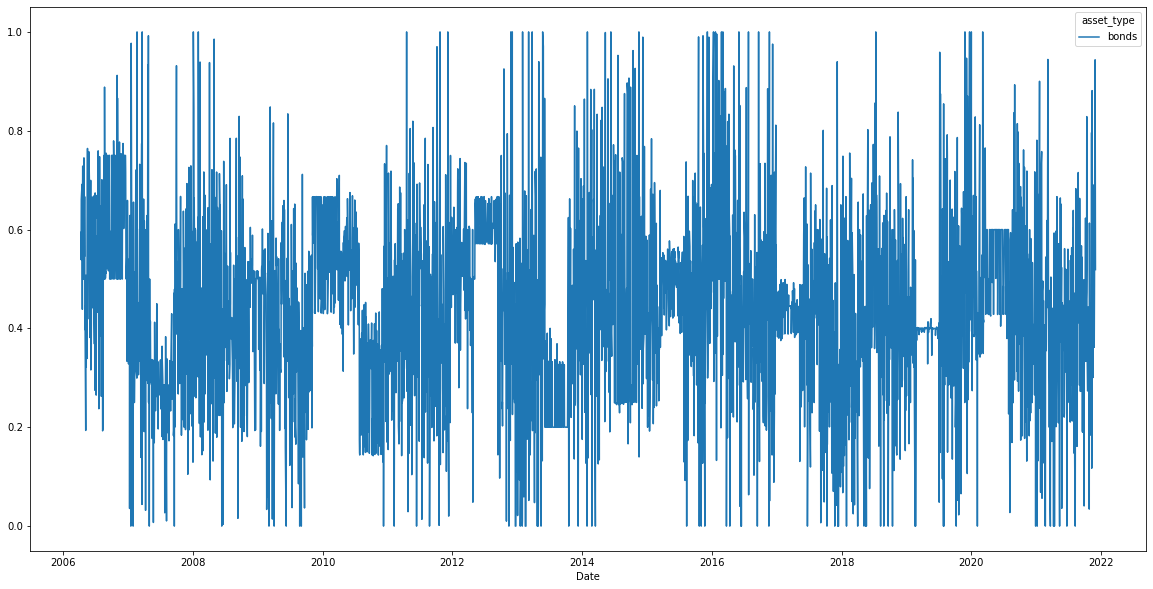

In [62]:
allocation_piv_df[["bonds"]].plot(figsize=(20,10))

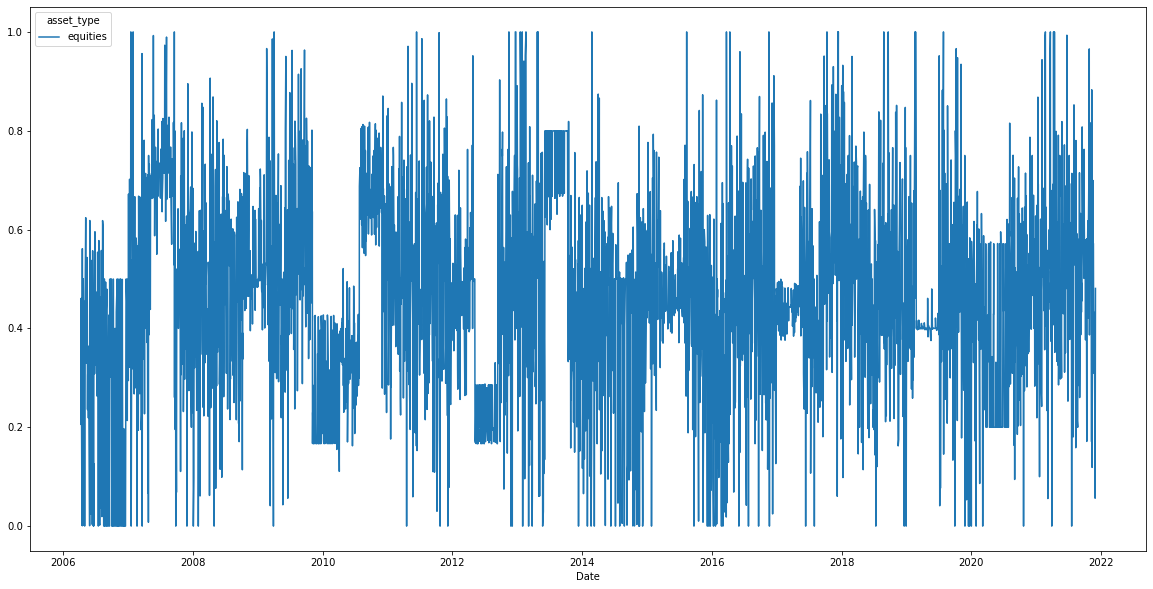

In [63]:
allocation_piv_df[["equities"]].plot(figsize=(20,10))

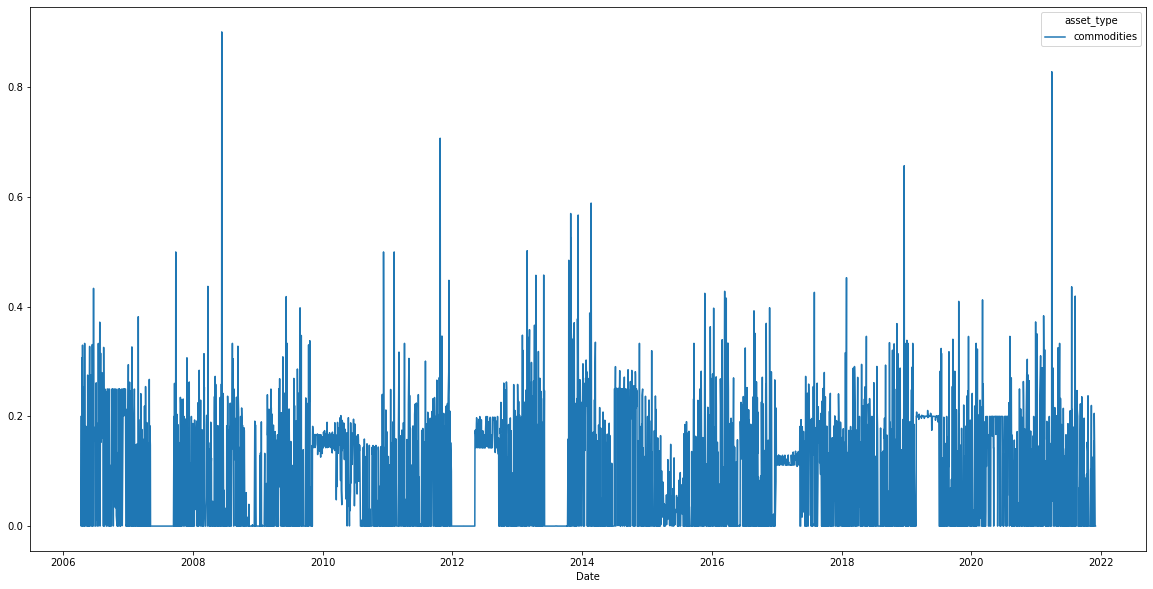

In [64]:
allocation_piv_df[["commodities"]].plot(figsize=(20,10))